In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
#  we will read the file 
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
# split the text into English-dari pairs
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
data = read_text("words.txt")
dari_eng = to_lines(data)
dari_eng = array(dari_eng)

In [6]:
dari_eng = dari_eng[:10000,:]

In [7]:
dari_eng

array([['dedication', 'اختصاص'],
       ['fernanda', 'فرناندا'],
       ['course', 'دوره'],
       ...,
       ['temperament', 'مزاج'],
       ['blends', 'مخلوط می شود'],
       ['get', 'گرفتن']], dtype='<U42')

In [8]:
# Remove punctuation
dari_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in dari_eng[:,0]]
dari_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in dari_eng[:,1]]

dari_eng

array([['dedication', 'اختصاص'],
       ['fernanda', 'فرناندا'],
       ['course', 'دوره'],
       ...,
       ['temperament', 'مزاج'],
       ['blends', 'مخلوط می شود'],
       ['get', 'گرفتن']], dtype='<U42')

In [9]:
# convert text to lowercase
for i in range(len(dari_eng)):
    dari_eng[i,0] = dari_eng[i,0].lower()
    dari_eng[i,1] = dari_eng[i,1].lower()

dari_eng

array([['dedication', 'اختصاص'],
       ['fernanda', 'فرناندا'],
       ['course', 'دوره'],
       ...,
       ['temperament', 'مزاج'],
       ['blends', 'مخلوط می شود'],
       ['get', 'گرفتن']], dtype='<U42')

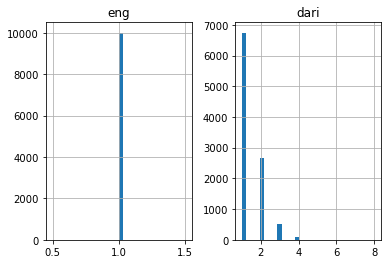

In [10]:
# empty lists
eng_l = []
dari_l = []

# populate the lists with sentence lengths
for i in dari_eng[:,0]:
      eng_l.append(len(i.split()))

for i in dari_eng[:,1]:
      dari_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'dari':dari_l})

length_df.hist(bins = 30)
plt.show()

In [11]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer
    
# prepare english tokenizer
eng_tokenizer = tokenization(dari_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 1
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 3688


In [12]:
# prepare Dari tokenizer
dari_tokenizer = tokenization(dari_eng[:, 1])
dari_vocab_size = len(dari_tokenizer.word_index) + 1

dari_length = 1
print('Dari Vocabulary Size: %d' % dari_vocab_size)

Deutch Vocabulary Size: 2770


In [13]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [14]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [15]:
# prepare training data
trainX = encode_sequences(dari_tokenizer, dari_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(dari_tokenizer, dari_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [16]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [17]:
# model compilation
model = define_model(dari_vocab_size, eng_vocab_size, dari_length, eng_length, 512)

In [18]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [19]:
filename = 'translation_model.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 8.1327
Epoch 00001: val_loss improved from inf to 7.45941, saving model to translation_model.h1
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: translation_model.h1\assets
13/13 [==============================] - 41s 3s/step - loss: 8.1327 - val_loss: 7.4594
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 7.1521
Epoch 00002: val_loss improved from 7.45941 to 7.11610, saving model to translation_model.h1
INFO:tensorflow:Assets written to: translation_model.h1\assets
13/13 [==============================] - 38s 3s/step - loss: 7.1521 - val_loss: 7.1161
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 6.9506
Epoch 00003: val_loss improved from 7.11610 to 7.04890, sav

INFO:tensorflow:Assets written to: translation_model.h1\assets
13/13 [==============================] - 37s 3s/step - loss: 1.9690 - val_loss: 4.3294
Epoch 25/30
13/13 [==============================] - ETA: 0s - loss: 1.8544
Epoch 00025: val_loss improved from 4.32937 to 4.27314, saving model to translation_model.h1
INFO:tensorflow:Assets written to: translation_model.h1\assets
13/13 [==============================] - 43s 3s/step - loss: 1.8544 - val_loss: 4.2731
Epoch 26/30
13/13 [==============================] - ETA: 0s - loss: 1.7520
Epoch 00026: val_loss improved from 4.27314 to 4.19865, saving model to translation_model.h1
INFO:tensorflow:Assets written to: translation_model.h1\assets
13/13 [==============================] - 41s 3s/step - loss: 1.7520 - val_loss: 4.1986
Epoch 27/30
13/13 [==============================] - ETA: 0s - loss: 1.6590
Epoch 00027: val_loss did not improve from 4.19865
13/13 [==============================] - 4s 322ms/step - loss: 1.6590 - val_loss: 4.2

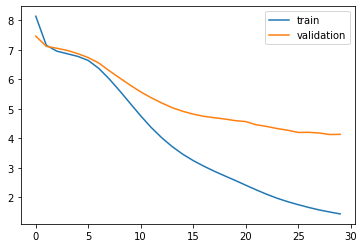

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [21]:
model = load_model('translation_model.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [22]:
# change predictiton to coresponding words
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [23]:
# Convert predictions into text (English):

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [24]:
# Let’s put the original English sentences in the test dataset and the predicted sentences in a dataframe:

pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [25]:
# print 15 rows randomly
pred_df.sample(15)

actual      predicted
1432          معمولا        usually
468          ترک کرد           died
350   به همان اندازه           size
432             دولت          state
817              کشف      discovery
1494            کتاب           book
1458        رو به رو         facing
789           کارآمد  interrogators
925       خود کنترلی    selfcontrol
1567              ما             us
1455      مانور دادن         change
1816           درجات          ranks
919             هنوز          still
1044           نقاشی       flinches
838       نتیجه گیری       decision